In [1]:
library(mmge)
library(expm)
library(MASS)

Loading required package: Matrix

Attaching package: ‘expm’

The following object is masked from ‘package:Matrix’:

    expm



In [2]:
devtools::reload(pkg=".")

ℹ Reloading attached mmge


# 1. generate shared graph structure

In [3]:
m = 5
n = 5
p = 100
q = 30

In [4]:
g = ceiling(q/10)

In [5]:
Adj.S = matrix(0, q, q)
for(i in 1:g){
    diag(Adj.S[1:(q-i),(1+i):q]) = 1
}
Adj.S = Adj.S + t(Adj.S)

# 2. generate precision matrices

## spatial precision matrix

In [6]:
power.S = 0.3

In [7]:
Omega.S = lapply(rep(0,m), function(x){
    Omega = matrix(0,q,q)
    Omega[upper.tri(Omega)] = (
        - runif(q*(q-1)/2, 0, power.S) * Adj.S[upper.tri(Adj.S)])
    Omega = Omega + t(Omega)
    if(min(eigen(Omega)$values)<0){
        Omega = Omega - 2*min(eigen(Omega)$values)*diag(q)
    }
    return(Omega)
})
Sigma.S = lapply(Omega.S, solve)

In [8]:
Rho.S = lapply(Omega.S, function(x){
    dgWh.S = array(rep(diag(x), q), c(q,q))
    return(x / aperm(sqrt(dgWh.S), c(2,1)) / sqrt(dgWh.S))
})

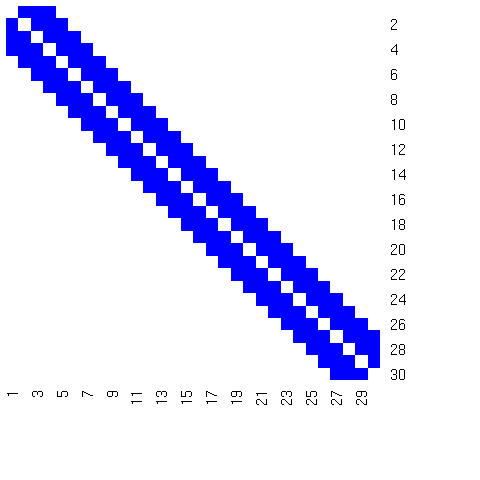

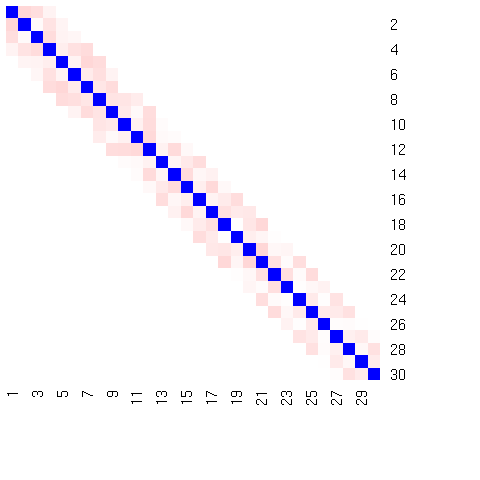

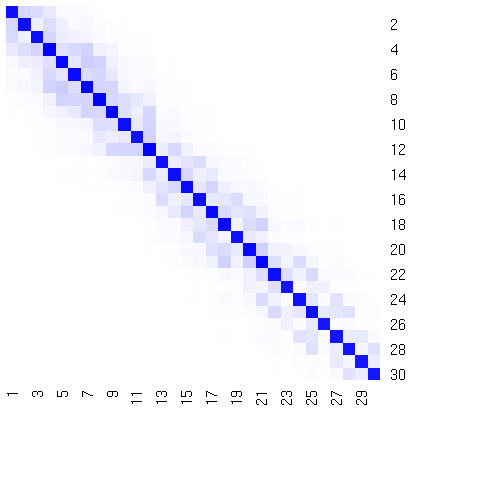

In [9]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(Adj.S)
imshow(Omega.S[[1]])
imshow(Sigma.S[[1]])

## temporal precision matrix

In [10]:
power.T = 0.2
decay.T = 1

In [11]:
beta.T = power.T * abs(outer(1:p,1:p,FUN='-'))**(-1-decay.T)
beta.T[upper.tri(beta.T, diag=TRUE)] = 0

In [12]:
Omega.T = lapply(rep(0, m), function(x){
    t(diag(p)-beta.T) %*% (diag(p)-beta.T)})
Sigma.T = lapply(Omega.T, solve)

In [13]:
Omega.T = lapply(1:m, function(l){
  Omega.T[[l]] * sum(diag(Sigma.T[[l]])) / p  
})

Sigma.T = lapply(1:m, function(l){
  Sigma.T[[l]] * p / sum(diag(Sigma.T[[l]]))
})

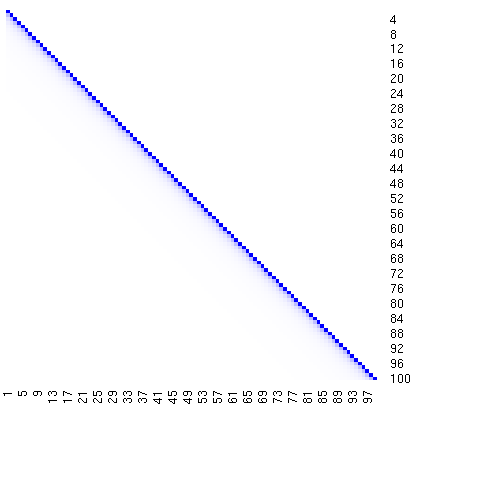

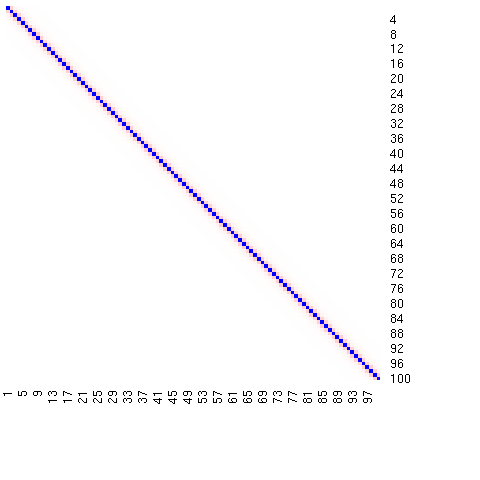

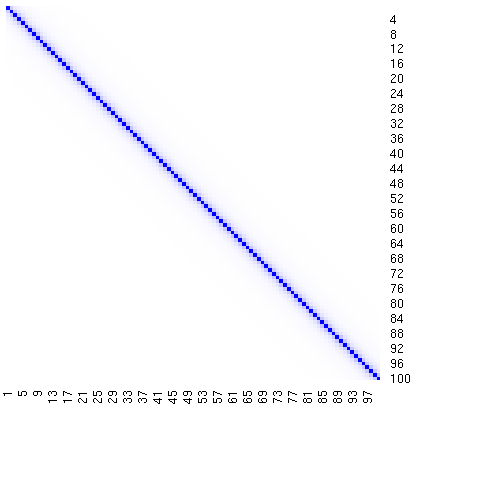

In [14]:
options(repr.plot.width=4, repr.plot.height=4)
imshow(beta.T)
imshow(Omega.T[[1]])
imshow(Sigma.T[[1]])

# 3. simulation data according to MGGM

In [15]:
data = lapply(1:m, function(l){
    n_l = n #floor(runif(1, n, 2*n))
    return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
        sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
    }), c(p,q,n_l)))
})

In [16]:
ns = sapply(data, function(x){dim(x)[3]})

In [17]:
sess.id = c(sapply(1:m, function(l){rep(l,ns[l])}))

In [18]:
T.S = Reduce(f = "+", lapply(1:m, function(l){
    sqrt(ns[l] * p / m) * Rho.S[[l]]
}), accumulate=FALSE)

# 4. estimation by the proposed method

In [19]:
est.T = est.temporal(data, order.T=5)

In [20]:
est.S = est.spatial(data, lambdas=1e-4)

# 5. global test for multiple edges

In [21]:
num.bst = 3000

## 5.1. $E_\text{off}$

In [22]:
E.mat.off = (diag(q) == 0)
E.mat.off[lower.tri(E.mat.off, diag = TRUE)] = 0
E.mat.off = E.mat.off != 0
num.E.off = sum(1*E.mat.off)
Cov.T.E.off = cov.multiple.edge(Omega.S, Sigma.T, ns, E.mat = E.mat.off)

In [23]:
inf.S.multi.off = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                                E.mat = E.mat.off, num.bst=num.bst)

### error distribution of test statistic estimate

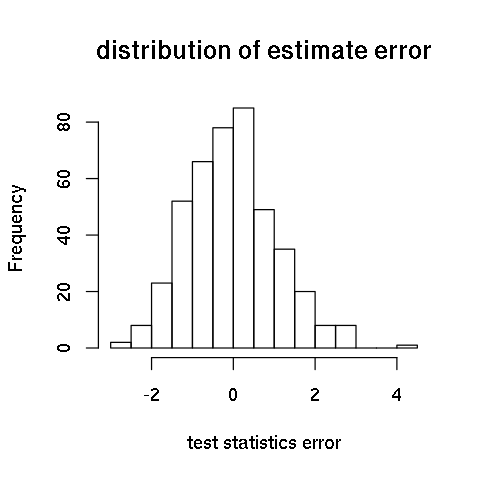

In [24]:
hist(inf.S.multi.off$T.hat.E[,1] - T.S[E.mat.off], 
     main = 'distribution of estimate error',
     xlab = 'test statistics error')

### bootstrap distribution

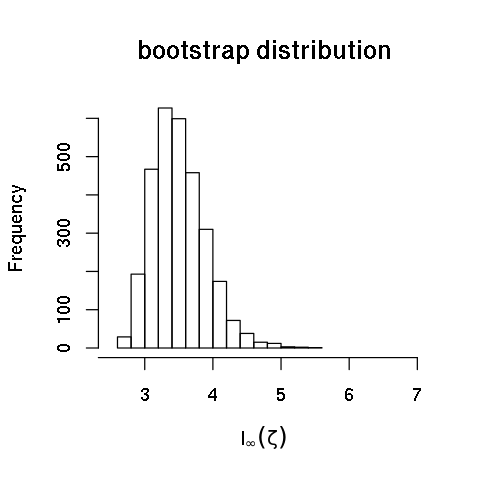

In [25]:
hist(inf.S.multi.off$l.inf.Z,
     main = 'bootstrap distribution',
     xlab = expression(l[infinity](zeta)), xlim = c(2.5, 7), xaxt="n")
abline(v = max(abs(inf.S.multi.off$T.hat.E[,1])), col='red')
axis(side=1, at=c(2, 3, 4, 5, 6, 7))

### p-value

In [26]:
inf.S.multi.off$p.value

[1] 0

## $E_\text{zero}$

In [27]:
E.mat.zero = !Adj.S
diag(E.mat.zero) = FALSE
E.mat.zero[lower.tri(E.mat.zero, diag = TRUE)] = 0
E.mat.zero = E.mat.zero != 0
num.E.zero = sum(1*E.mat.zero)
Cov.T.E.zero = cov.multiple.edge(Omega.S, Sigma.T, ns, E.mat = E.mat.zero)

In [28]:
inf.S.multi.zero = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                                     E.mat = E.mat.zero, num.bst=num.bst)

### error distribution of test statistic estimate

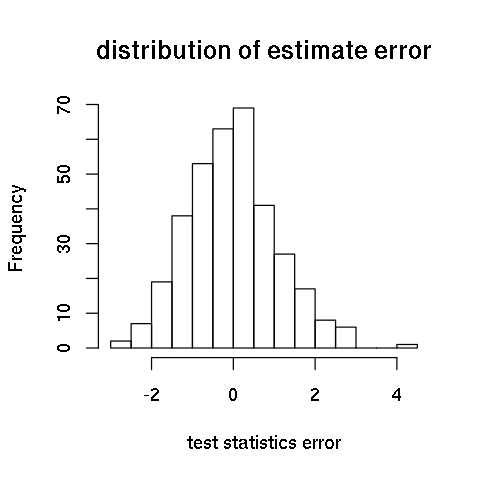

In [29]:
hist(inf.S.multi.zero$T.hat.E[,1] - T.S[E.mat.zero], 
     main = 'distribution of estimate error',
     xlab = 'test statistics error')

### bootstrap distribution

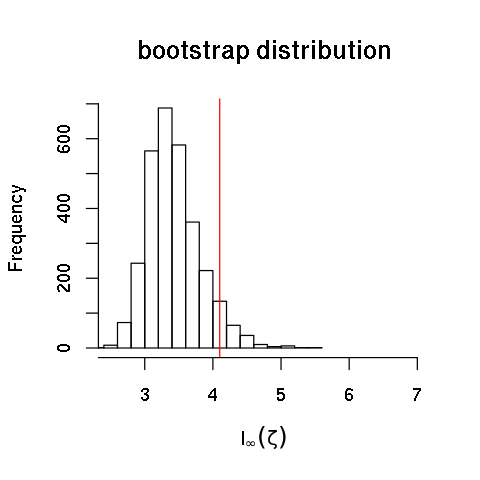

In [30]:
hist(inf.S.multi.zero$l.inf.Z,
     main = 'bootstrap distribution',
     xlab = expression(l[infinity](zeta)), xlim = c(2.5, 7), xaxt="n")
abline(v = max(abs(inf.S.multi.zero$T.hat.E[,1])), col='red')
axis(side=1, at=c(2, 3, 4, 5, 6, 7))

### p-value

In [31]:
inf.S.multi.zero$p.value

[1] 0.05966667

# 6. iterate simulation for empirical distirbution of test statistic

In [47]:
num.sim = 1000

In [33]:
T.hat.sim = array(0, c(q,q,num.sim))

In [34]:
for( i.sim in 1:num.sim ){
    time.sim = proc.time()
    
    data = lapply(1:m, function(l){
        n_l = n #floor(runif(1, n, 2*n))
        return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
            sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
        }), c(p,q,n_l)))
    })    
    
    est.T = est.temporal(data, order.T=5)
    est.S = est.spatial(data, lambdas=1e-4)
    inf.S = inf.single.edge(est.S$W.hat.S, est.T$S.hat.T, ns)
    T.hat.sim[,,i.sim] = inf.S$T.hat
    
    cat(i.sim,'-th simulation finished, lapse: ',(proc.time()-time.sim)[3],'sec. \n') 
    flush.console()
}

1 -th simulation finished, lapse:  8.119 sec. 
2 -th simulation finished, lapse:  5.786 sec. 
3 -th simulation finished, lapse:  7.427 sec. 
4 -th simulation finished, lapse:  8.336 sec. 
5 -th simulation finished, lapse:  7.609 sec. 
6 -th simulation finished, lapse:  8.948 sec. 
7 -th simulation finished, lapse:  5.63 sec. 
8 -th simulation finished, lapse:  8.965 sec. 
9 -th simulation finished, lapse:  8.706 sec. 
10 -th simulation finished, lapse:  8.24 sec. 
11 -th simulation finished, lapse:  6.875 sec. 
12 -th simulation finished, lapse:  7.01 sec. 
13 -th simulation finished, lapse:  6.281 sec. 
14 -th simulation finished, lapse:  9.318 sec. 
15 -th simulation finished, lapse:  5.584 sec. 
16 -th simulation finished, lapse:  11.269 sec. 
17 -th simulation finished, lapse:  8.401 sec. 
18 -th simulation finished, lapse:  7.056 sec. 
19 -th simulation finished, lapse:  7.313 sec. 
20 -th simulation finished, lapse:  6.874 sec. 
21 -th simulation finished, lapse:  9.911 sec. 
22 

171 -th simulation finished, lapse:  5.565 sec. 
172 -th simulation finished, lapse:  5.088 sec. 
173 -th simulation finished, lapse:  5.478 sec. 
174 -th simulation finished, lapse:  6.618 sec. 
175 -th simulation finished, lapse:  6.278 sec. 
176 -th simulation finished, lapse:  6.932 sec. 
177 -th simulation finished, lapse:  7.333 sec. 
178 -th simulation finished, lapse:  8.219 sec. 
179 -th simulation finished, lapse:  10.905 sec. 
180 -th simulation finished, lapse:  8.938 sec. 
181 -th simulation finished, lapse:  8.046 sec. 
182 -th simulation finished, lapse:  9.276 sec. 
183 -th simulation finished, lapse:  9.045 sec. 
184 -th simulation finished, lapse:  9.754 sec. 
185 -th simulation finished, lapse:  11.829 sec. 
186 -th simulation finished, lapse:  10.336 sec. 
187 -th simulation finished, lapse:  9.062 sec. 
188 -th simulation finished, lapse:  7.997 sec. 
189 -th simulation finished, lapse:  9.828 sec. 
190 -th simulation finished, lapse:  7.588 sec. 
191 -th simulatio

338 -th simulation finished, lapse:  13.352 sec. 
339 -th simulation finished, lapse:  9.89 sec. 
340 -th simulation finished, lapse:  8.826 sec. 
341 -th simulation finished, lapse:  12.109 sec. 
342 -th simulation finished, lapse:  9.52 sec. 
343 -th simulation finished, lapse:  8.001 sec. 
344 -th simulation finished, lapse:  9.412 sec. 
345 -th simulation finished, lapse:  9.799 sec. 
346 -th simulation finished, lapse:  10.701 sec. 
347 -th simulation finished, lapse:  8.982 sec. 
348 -th simulation finished, lapse:  8.77 sec. 
349 -th simulation finished, lapse:  9.389 sec. 
350 -th simulation finished, lapse:  7.893 sec. 
351 -th simulation finished, lapse:  12.452 sec. 
352 -th simulation finished, lapse:  8.861 sec. 
353 -th simulation finished, lapse:  8.629 sec. 
354 -th simulation finished, lapse:  11.051 sec. 
355 -th simulation finished, lapse:  9.317 sec. 
356 -th simulation finished, lapse:  8.477 sec. 
357 -th simulation finished, lapse:  10.812 sec. 
358 -th simulatio

505 -th simulation finished, lapse:  10.482 sec. 
506 -th simulation finished, lapse:  9.74 sec. 
507 -th simulation finished, lapse:  8.593 sec. 
508 -th simulation finished, lapse:  9.381 sec. 
509 -th simulation finished, lapse:  9.123 sec. 
510 -th simulation finished, lapse:  8.455 sec. 
511 -th simulation finished, lapse:  10.439 sec. 
512 -th simulation finished, lapse:  11.885 sec. 
513 -th simulation finished, lapse:  13.85 sec. 
514 -th simulation finished, lapse:  8.827 sec. 
515 -th simulation finished, lapse:  13.676 sec. 
516 -th simulation finished, lapse:  11.861 sec. 
517 -th simulation finished, lapse:  13.087 sec. 
518 -th simulation finished, lapse:  12.791 sec. 
519 -th simulation finished, lapse:  8.901 sec. 
520 -th simulation finished, lapse:  12.034 sec. 
521 -th simulation finished, lapse:  12.264 sec. 
522 -th simulation finished, lapse:  9.982 sec. 
523 -th simulation finished, lapse:  9.493 sec. 
524 -th simulation finished, lapse:  10.245 sec. 
525 -th sim

682 -th simulation finished, lapse:  12.123 sec. 
683 -th simulation finished, lapse:  8.256 sec. 
684 -th simulation finished, lapse:  9.552 sec. 
685 -th simulation finished, lapse:  10.166 sec. 
686 -th simulation finished, lapse:  8.766 sec. 
687 -th simulation finished, lapse:  12.295 sec. 
688 -th simulation finished, lapse:  11.672 sec. 
689 -th simulation finished, lapse:  14.374 sec. 
690 -th simulation finished, lapse:  11.265 sec. 
691 -th simulation finished, lapse:  11.259 sec. 
692 -th simulation finished, lapse:  10.661 sec. 
693 -th simulation finished, lapse:  10.773 sec. 
694 -th simulation finished, lapse:  11.864 sec. 
695 -th simulation finished, lapse:  10.496 sec. 
696 -th simulation finished, lapse:  9.57 sec. 
697 -th simulation finished, lapse:  9.198 sec. 
698 -th simulation finished, lapse:  8.898 sec. 
699 -th simulation finished, lapse:  10.035 sec. 
700 -th simulation finished, lapse:  9.621 sec. 
701 -th simulation finished, lapse:  9.618 sec. 
702 -th s

848 -th simulation finished, lapse:  9.484 sec. 
849 -th simulation finished, lapse:  10.162 sec. 
850 -th simulation finished, lapse:  8.521 sec. 
851 -th simulation finished, lapse:  9.726 sec. 
852 -th simulation finished, lapse:  8.198 sec. 
853 -th simulation finished, lapse:  7.579 sec. 
854 -th simulation finished, lapse:  11.409 sec. 
855 -th simulation finished, lapse:  13.409 sec. 
856 -th simulation finished, lapse:  10.264 sec. 
857 -th simulation finished, lapse:  11.966 sec. 
858 -th simulation finished, lapse:  7.339 sec. 
859 -th simulation finished, lapse:  10.391 sec. 
860 -th simulation finished, lapse:  12.702 sec. 
861 -th simulation finished, lapse:  12.003 sec. 
862 -th simulation finished, lapse:  10.914 sec. 
863 -th simulation finished, lapse:  8.169 sec. 
864 -th simulation finished, lapse:  10.439 sec. 
865 -th simulation finished, lapse:  9.882 sec. 
866 -th simulation finished, lapse:  10.609 sec. 
867 -th simulation finished, lapse:  6.115 sec. 
868 -th s

## empirical distribution of simulated test statistics

In [35]:
T.hat.E.off = apply(T.hat.sim, 3, function(T.hat){ T.hat[E.mat.off] })
l.inf.T.off = apply(T.hat.E.off, 2, function(T.hat){ max(abs(T.hat)) })

In [36]:
l.inf.dT.off = apply(T.hat.E.off - T.S[E.mat.off],
                     2, function(T.hat){ max(abs(T.hat)) })

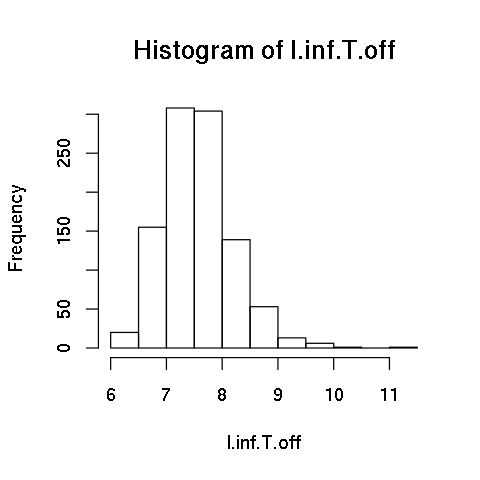

In [37]:
hist(l.inf.T.off)

In [38]:
T.hat.E.zero = apply(T.hat.sim, 3, function(T.hat){ T.hat[E.mat.zero] })
l.inf.T.zero = apply(T.hat.E.zero, 2, function(T.hat){ max(abs(T.hat)) })

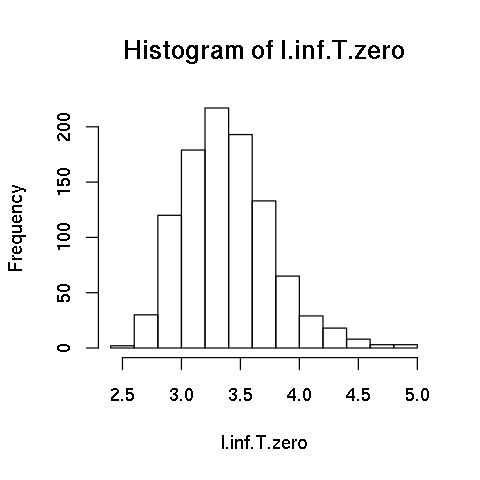

In [39]:
hist(l.inf.T.zero)

## comparison between simulation and bootstrap distributions

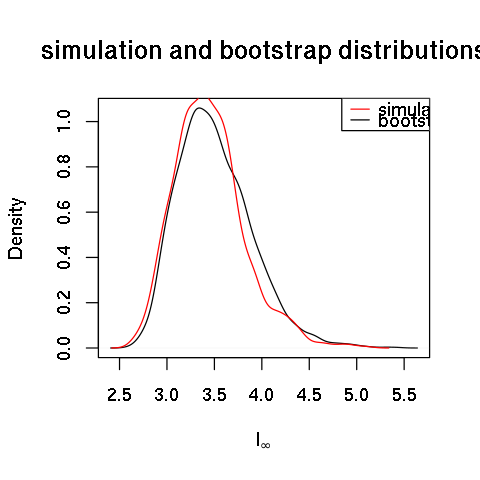

In [40]:
plot(density(inf.S.multi.off$l.inf.Z), col='black',
     main = 'simulation and bootstrap distributions',
     xlab = expression(l[infinity]))
lines(density(l.inf.dT.off), col='red')
legend('topright',
       legend=c('simulation','bootstrap'), 
       col=c('red','black'), lty=c(1,1))

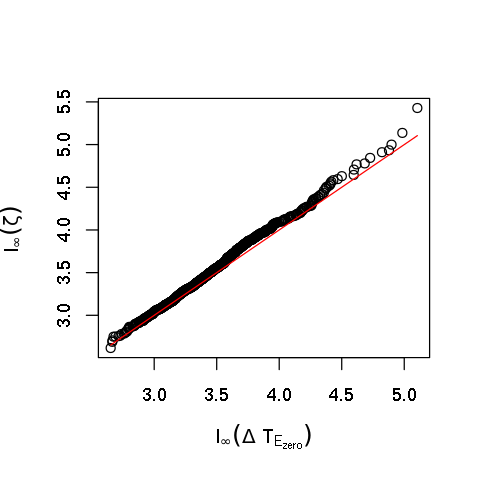

In [41]:
qqplot(l.inf.dT.off, inf.S.multi.off$l.inf.Z,
       xlab=expression(l[infinity](Delta~T[E[zero]])),
       ylab=expression(l[infinity](zeta)))
lines(l.inf.dT.off, l.inf.dT.off, col='red')

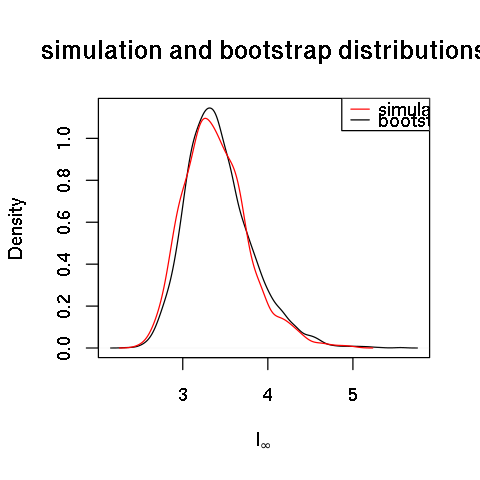

In [42]:
plot(density(inf.S.multi.zero$l.inf.Z), col='black',
     main = 'simulation and bootstrap distributions',
     xlab = expression(l[infinity]))
lines(density(l.inf.T.zero), col='red')
legend('topright',
       legend=c('simulation','bootstrap'), 
       col=c('red','black'), lty=c(1,1))

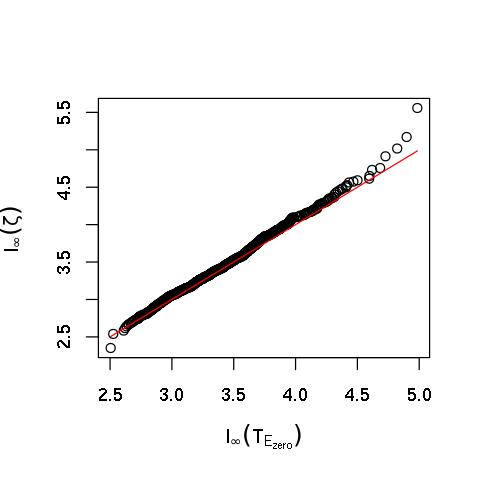

In [43]:
qqplot(l.inf.T.zero, inf.S.multi.zero$l.inf.Z,
       xlab=expression(l[infinity](T[E[zero]])),
       ylab=expression(l[infinity](zeta)))
lines(l.inf.T.zero, l.inf.T.zero, col='red')

In [44]:
# save(Adj.S, Omega.S, Sigma.S, Omega.T, Sigma.T, 
#      inf.S.multi.off, inf.S.multi.zero, 
#      T.hat.sim, file='sim_band_multi.Rdata')

# 7. Coverage study

In [46]:
num.msim = 100

## $E_\text{off}$

In [49]:
T.hat.E.sim = array(0, c(num.E.off,num.msim))
l.inf.Z.sim = array(0, c(num.bst,num.msim))
p.value.sim = rep(0, num.msim)

In [50]:
for( i.sim in 1:num.msim ){
    time.sim = proc.time()
    
    data = lapply(1:m, function(l){
        n_l = n #floor(runif(1, n, 2*n))
        return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
            sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
        }), c(p,q,n_l)))
    })    
    
    est.T = est.temporal(data, order.T=5)
    est.S = est.spatial(data, lambdas=1e-4)
    inf.S = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                              E.mat=E.mat.off, num.bst=num.bst)
    
    T.hat.E.sim[,i.sim] = inf.S$T.hat.E
    l.inf.Z.sim[,i.sim] = inf.S$l.inf.Z
    p.value.sim[i.sim] = inf.S$p.value
    
    cat(i.sim,'-th simulation finished, lapse: ',(proc.time()-time.sim)[3],'sec. \n') 
    flush.console()
}

1 -th simulation finished, lapse:  20.329 sec. 
2 -th simulation finished, lapse:  22.287 sec. 
3 -th simulation finished, lapse:  22.063 sec. 
4 -th simulation finished, lapse:  21.516 sec. 
5 -th simulation finished, lapse:  20.595 sec. 
6 -th simulation finished, lapse:  22.732 sec. 
7 -th simulation finished, lapse:  21.606 sec. 
8 -th simulation finished, lapse:  22.205 sec. 
9 -th simulation finished, lapse:  22.78 sec. 
10 -th simulation finished, lapse:  21.385 sec. 
11 -th simulation finished, lapse:  25.504 sec. 
12 -th simulation finished, lapse:  21.414 sec. 
13 -th simulation finished, lapse:  23.211 sec. 
14 -th simulation finished, lapse:  20.17 sec. 
15 -th simulation finished, lapse:  21.426 sec. 
16 -th simulation finished, lapse:  20.595 sec. 
17 -th simulation finished, lapse:  20.744 sec. 
18 -th simulation finished, lapse:  21.549 sec. 
19 -th simulation finished, lapse:  21.543 sec. 
20 -th simulation finished, lapse:  21.584 sec. 
21 -th simulation finished, lap

In [52]:
# l.inf.dT.sim = apply(T.hat.E.sim - T.S[E.mat.off],
#                      2, function(T.hat){ max(abs(T.hat)) })

In [51]:
q.Z.sim = apply(l.inf.Z.sim, 2, function(l){
    quantile(l, c(0.925, 0.95, 0.975))
})

In [52]:
q.dT.sim = apply(q.Z.sim, 2, function(q){
    sapply(q, function(x){ mean(l.inf.dT.off < x) })
})

In [53]:
apply(q.dT.sim, 1, mean)

92.5%     95%   97.5% 
0.94062 0.96041 0.98410

In [54]:
apply(q.dT.sim, 1, sd)

92.5%         95%       97.5% 
0.003902291 0.003130479 0.003023477

In [55]:
# save(Adj.S, Omega.S, Sigma.S, Omega.T, Sigma.T, 
#      E.mat.off, l.inf.dT.off, l.inf.Z.sim, p.value.sim,
#      file='sim_band_multi_off.Rdata')

## $E_\text{zero}$

In [58]:
T.hat.E.sim = array(0, c(num.E.zero,num.msim))
l.inf.Z.sim = array(0, c(num.bst,num.msim))
p.value.sim = rep(0, num.msim)

In [59]:
for( i.sim in 1:num.msim ){
    time.sim = proc.time()
    
    data = lapply(1:m, function(l){
        n_l = n #floor(runif(1, n, 2*n))
        return(array(apply(array(rnorm(p*q*n_l), c(p,q,n_l)), 3, function(x){
            sqrtm(Sigma.T[[l]]) %*% x %*% sqrtm(Sigma.S[[l]])
        }), c(p,q,n_l)))
    })    
    
    est.T = est.temporal(data, order.T=5)
    est.S = est.spatial(data, lambdas=1e-4)
    inf.S = inf.multiple.edge(est.S$W.hat.S, est.T$S.hat.T, ns,
                              E.mat=E.mat.zero, num.bst=num.bst)
    
    T.hat.E.sim[,i.sim] = inf.S$T.hat.E
    l.inf.Z.sim[,i.sim] = inf.S$l.inf.Z
    p.value.sim[i.sim] = inf.S$p.value
    
    cat(i.sim,'-th simulation finished, lapse: ',(proc.time()-time.sim)[3],'sec. \n') 
    flush.console()
}

1 -th simulation finished, lapse:  14.483 sec. 
2 -th simulation finished, lapse:  14.288 sec. 
3 -th simulation finished, lapse:  14.266 sec. 
4 -th simulation finished, lapse:  14.399 sec. 
5 -th simulation finished, lapse:  14.572 sec. 
6 -th simulation finished, lapse:  14.139 sec. 
7 -th simulation finished, lapse:  13.668 sec. 
8 -th simulation finished, lapse:  14.143 sec. 
9 -th simulation finished, lapse:  13.132 sec. 
10 -th simulation finished, lapse:  13.258 sec. 
11 -th simulation finished, lapse:  13.619 sec. 
12 -th simulation finished, lapse:  14.351 sec. 
13 -th simulation finished, lapse:  13.098 sec. 
14 -th simulation finished, lapse:  13.187 sec. 
15 -th simulation finished, lapse:  13.594 sec. 
16 -th simulation finished, lapse:  14.33 sec. 
17 -th simulation finished, lapse:  13.077 sec. 
18 -th simulation finished, lapse:  13.205 sec. 
19 -th simulation finished, lapse:  13.578 sec. 
20 -th simulation finished, lapse:  14.272 sec. 
21 -th simulation finished, la

In [ ]:
# l.inf.dT.sim = apply(T.hat.E.sim - T.S[E.mat.off],
#                      2, function(T.hat){ max(abs(T.hat)) })

In [60]:
q.Z.sim = apply(l.inf.Z.sim, 2, function(l){
    quantile(l, c(0.925, 0.95, 0.975))
})

In [61]:
q.dT.sim = apply(q.Z.sim, 2, function(q){
    sapply(q, function(x){ mean(l.inf.T.zero < x) })
})

In [62]:
apply(q.dT.sim, 1, mean)

92.5%     95%   97.5% 
0.94317 0.96078 0.98285

In [63]:
apply(q.dT.sim, 1, sd)

92.5%         95%       97.5% 
0.002518838 0.004205768 0.002544056

In [64]:
save(Adj.S, Omega.S, Sigma.S, Omega.T, Sigma.T, 
     E.mat.zero, l.inf.T.zero, l.inf.Z.sim, p.value.sim,
     file='sim_band_multi_zero.Rdata')